In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.label=label
        self.grad=0.0
        self._backward=lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other=other if isinstance(other, Value) else Value(other)
        out=Value(self.data+other.data, (self, other), '+')
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
        return out
    def __radd__(self, other):
        return self+other
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self, other): # self-other
        return self+(-other)
    
    def __mul__(self, other):
        other=other if isinstance(other, Value) else Value(other)
        out=Value(self.data*other.data, (self, other), '*')
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
    def __rmul__(self, other): # other*self
        return self*other
    
    def __truediv__(self, other):
        return self*other**-1
    
    def  __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out=Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad+=(other*(self.data**(other-1)))*out.grad
        out._backward=_backward
        return out
        
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t, (self, ), 'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out 
    
    def exp(self):
        x=self.data
        out=Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward
        return out
    
    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()

In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges=set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in (v._prev):
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot=Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR=left to right
    nodes, edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation create a op node for it
            dot.node(name=uid+n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
        
    return dot

In [4]:
# inputs x1, x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

# weights w1, w2
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

# bias of the neuron
b=Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n=x1w1x2w2+b; n.label='n'
o=n.tanh(); o.label='o'
o.backward()

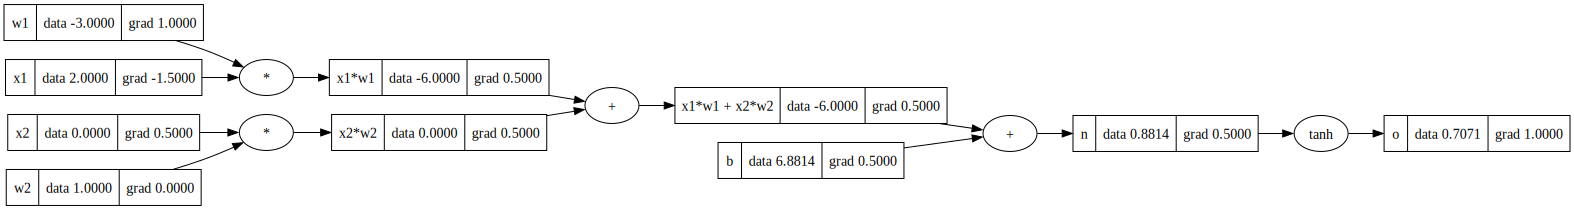

In [5]:
draw_dot(o)

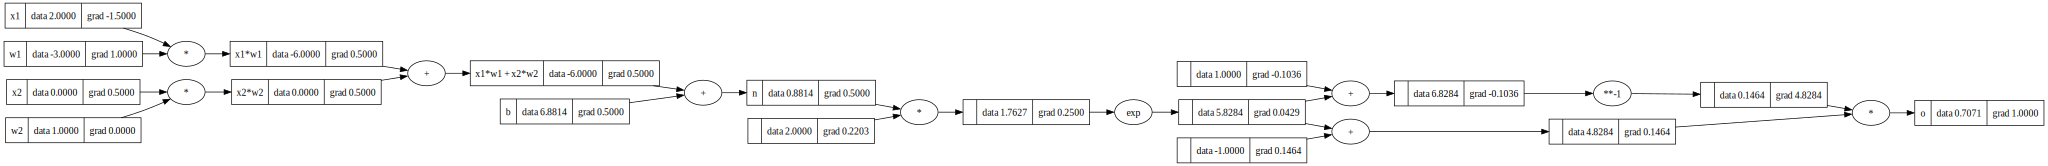

In [6]:
# inputs x1, x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
# weights w1, w2
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
# bias of the neuron
b=Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n=x1w1x2w2+b; n.label='n'

e=(2*n).exp()
o=(e-1)/(e+1)

o.label='o'
o.backward()
draw_dot(o)

In [12]:
# Using pytorch to validate

import torch
x1=torch.Tensor([2.0]).double();     x1.requires_grad = True
x2=torch.Tensor([0.0]).double();     x2.requires_grad = True
w1=torch.Tensor([-3.0]).double();     w1.requires_grad = True
w2=torch.Tensor([1.0]).double();     w2.requires_grad = True
b=torch.Tensor([6.8813735870195432]).double();     b.requires_grad=True
n=x1*w1 + x2*w2 + b
o=torch.tanh(n)

print(o.data.item())
o.backward()

print('---------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [13]:
class Neuron:
    def __init__(self, nin):
        self.w=[Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act=sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out=act.tanh()
        return out
   
    def parameters(self):
        return self.w+[self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: # multi layer perceptron
    def __init__(self, nin, nouts):
        sz=[nin]+nouts
        self.layers=[Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [15]:
n=MLP(3, [4, 4, 1])

In [16]:
n.parameters()

[Value(data=-0.7783307806969184),
 Value(data=-0.09457063867455373),
 Value(data=0.3576198163759883),
 Value(data=-0.3121560144872768),
 Value(data=-0.8391290685818364),
 Value(data=-0.8411164528938853),
 Value(data=0.26573782691311987),
 Value(data=-0.2991634132914198),
 Value(data=-0.955978175449008),
 Value(data=-0.45466135330444324),
 Value(data=0.675182968526407),
 Value(data=-0.0757979420890389),
 Value(data=0.4204900039717796),
 Value(data=0.12770831303574948),
 Value(data=-0.6056539001995758),
 Value(data=-0.9793941799525652),
 Value(data=0.7251694241521192),
 Value(data=0.8550109019033776),
 Value(data=0.04103752297937002),
 Value(data=-0.31196450438877243),
 Value(data=0.2801770459064641),
 Value(data=-0.7473534839745093),
 Value(data=-0.626108457802812),
 Value(data=0.7255039269368784),
 Value(data=-0.5032518081819135),
 Value(data=-0.019646953590823246),
 Value(data=-0.8217465623545896),
 Value(data=-0.3314259245303961),
 Value(data=-0.14624005800609363),
 Value(data=0.1342

In [17]:
xs=[
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys=[1.0, -1.0, -1.0, 1.0] # desired targets

In [18]:
for k in range(20):
    # forward pass
    ypred=[n(x) for x in xs]
    loss=sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad=0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05*p.grad
        
    print(k, loss.data)

0 4.88592472751556
1 3.8413082889210375
2 3.3270427546861208
3 3.0540766552349585
4 2.902087847353251
5 2.7956899761101255
6 2.684432759539922
7 2.5098037104025193
8 2.190631630568331
9 1.6963406353411705
10 1.1603558028075027
11 0.7668124031644352
12 0.528669200834974
13 0.38758309343541847
14 0.29897616720398057
15 0.24180961502393863
16 0.20248356192552414
17 0.17373643038838144
18 0.15188150666473857
19 0.13475565514254306


In [19]:
ypred

[Value(data=0.8551337402375659),
 Value(data=-0.7660858033199917),
 Value(data=-0.923241048162108),
 Value(data=0.7694319323295601)]

The goal of training a neural network is to minimize the loss function by adjusting the weights and biases of the network. This is done through an optimization algorithm, such as gradient descent. In gradient descent, the network parameters are updated iteratively by moving in the direction opposite to the gradient of the loss function with respect to the parameters.
new_val = old_val - (dy/dx)*learning_rate
dy/dx is nothing but gradient or the slope
Goal is to minimize
first the algorithm makes a random guess
with the help of gradient, it is decided where to move
slope=-ve, new_value > old value
slope=-ve, new_value < old value

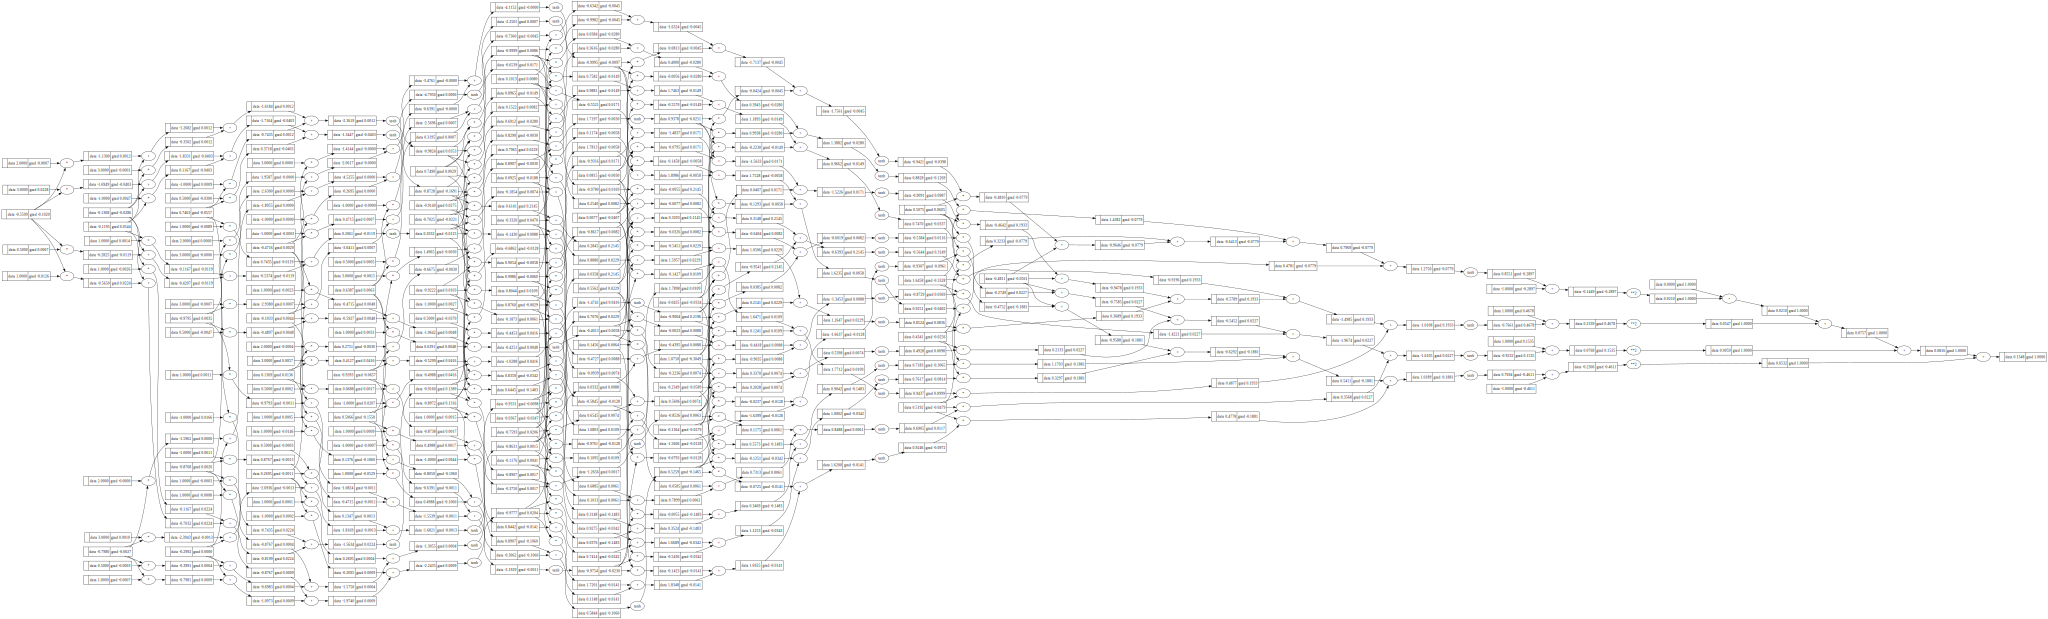

In [20]:
draw_dot(loss)